# Understanding errors in kalman gains

## Preliminaries

### Load packages

In [1]:
import numpy as np
import xarray as xr
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
cd /Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts


In [3]:
from post_processing_fns import *
from letkf import *

In [4]:
which_columns2 = {
  'lons' : [-154.5, 35.5, 75.5, -150.5, 160.5],
  'lats' : [-27.5, -49.5, -31.5, 12.5, 40.5],
  'name' : ['South Pacific', 'Southern Ocean', 'Indian Ocean', 'Tropical Pacific', 'North Pacific'],
  'save_name' : ['south_pacific2', 'southern_ocean2', 'indian_ocean2', 'tropical_pacific2', 'north_pacific']
}

In [5]:
these_columns = which_columns2

In [6]:
## Where are we working
proj_dir = '/Users/zstanley/Documents/git_repos/obs_loc_for_scda'
plot_dir = proj_dir + '/plots/understanding_metrics/kalman_gain/'
my_data_dir = proj_dir + '/my_data/20151206.030000'
nb_dir = proj_dir + '/notebooks'

### Load data

In [7]:
## Load vertical columns
south_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][0]+'.nc')
southern_ocean = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][1]+'.nc')
indian_ocean = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][2]+'.nc')
tropical_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][3]+'.nc')
north_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][4]+'.nc')

In [8]:
# Load covariance matrices
sp_cov = np.load(my_data_dir +'/'+these_columns['save_name'][0]+'_cov.npy')
so_cov = np.load(my_data_dir +'/'+these_columns['save_name'][1]+'_cov.npy')
io_cov = np.load(my_data_dir +'/'+these_columns['save_name'][2]+'_cov.npy')
tp_cov = np.load(my_data_dir +'/'+these_columns['save_name'][3]+'_cov.npy')
np_cov = np.load(my_data_dir +'/'+these_columns['save_name'][4]+'_cov.npy')

In [9]:
# Load correlation matrices
sp_cor = np.load(my_data_dir +'/'+these_columns['save_name'][0]+'_cor.npy')
so_cor = np.load(my_data_dir +'/'+these_columns['save_name'][1]+'_cor.npy')
io_cor = np.load(my_data_dir +'/'+these_columns['save_name'][2]+'_cor.npy')
tp_cor = np.load(my_data_dir +'/'+these_columns['save_name'][3]+'_cor.npy')
np_cor = np.load(my_data_dir +'/'+these_columns['save_name'][4]+'_cor.npy')

### Process data

In [10]:
# Compute atm pressure from pressure thickness of each level
south_pacific['atm_p'] = south_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
southern_ocean['atm_p'] = southern_ocean['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
indian_ocean['atm_p'] = indian_ocean['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
tropical_pacific['atm_p'] = tropical_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2
north_pacific['atm_p'] = north_pacific['atm_delp'].mean('ens_mem').cumsum(dim='atm_lev') / 1e2

In [11]:
## Get indices of relevant pressure levels in atm and depth levels in ocn
# atmosphere
num_atm_levs = len(south_pacific['atm_lev'])
ind_ast = num_atm_levs - 1
ind100hPa = np.argmin(np.abs(south_pacific['atm_p'].mean(['lat', 'lon']).values-100))
ind800hPa = np.argmin(np.abs(south_pacific['atm_p'].mean(['lat', 'lon']).values-800))
# ocean
ind0m = num_atm_levs
ind150m_ocn = np.argmin(np.abs(south_pacific['ocn_lev'].values-150))
ind2km_ocn  = np.argmin(np.abs(south_pacific['ocn_lev'].values-2000))
num_ocn_levs = len(south_pacific['ocn_lev'])
# both
ind150m = ind0m + ind150m_ocn
ind2km = ind0m + ind2km_ocn
num_tot_levs = num_atm_levs + num_ocn_levs

In [12]:
def get_column_mean(ds):
    # initialize array
    num_atm_levs = len(ds['atm_lev'])
    num_ocn_levs = len(ds['ocn_lev'])
    num_tot_levs = num_atm_levs + num_ocn_levs
    ds_manual = np.empty(num_tot_levs)
    # Get mean of atm bootstrapped ensemble
    ds_atm = ds['atm_T'].mean(['lat', 'lon', 'ens_mem'])
    ds_atm = ds_atm.to_numpy()
    # Get mean of ocn bootstrapped ensemble
    ds_ocn = ds['ocn_Temp'].mean(['lat', 'lon', 'ens_mem'])
    ds_ocn = ds_ocn.to_numpy()
    # Store atm and ocn temperature mean
    ds_manual[:num_atm_levs] = ds_atm - 273.15
    ds_manual[num_atm_levs:num_tot_levs] = ds_ocn
    ds_manual = np.atleast_2d(ds_manual).transpose()
    return ds_manual

In [13]:
# Get mean temperature profiles
sp_avg = get_column_mean(south_pacific)
so_avg = get_column_mean(southern_ocean)
io_avg = get_column_mean(indian_ocean)
tp_avg = get_column_mean(tropical_pacific)
np_avg = get_column_mean(north_pacific)

### Define parameters

In [14]:
# Define a range of localization radii for ocn and atm
loc_rads_ocn = [5, 15, 30, 40, 50, 60, 70, 80, 100, 200]
loc_rads_atm = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2]
loc_rads_crs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 1.5, 2]
loc_rad_noloc = 1e5

## Assimilate AST into ATM

### Plot each part of the metric

In [15]:
def compute_analysis(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, use_loc=True):
    ## Set observation operator
    num_levs = this_cov.shape[0]
    HofX = np.zeros((1, num_levs))
    HofX[0, ind_ob] = 1
    
    ## Generate synthetic observations
    xt = this_avg + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1)) 
    y_ob = HofX @ ( xt + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1))) # obs error set to equal 'perfect' background error
    
    ## Generate ensemble
    rnd = np.random.normal(size=(num_levs, ens_size))
    x_err_ens = this_cov_sqrt @ rnd
    P_ens = np.cov(x_err_ens)
    x_ens = this_avg + x_err_ens

    ## Form background observation perturbations
    y_ens = HofX @ x_ens
    
    ## Set observation error variance equal to true variance
    R = HofX @ this_cov @ HofX.transpose()
    R_inv = np.reciprocal(R)
    
    ## Calculate analysis increments
    background_mean = np.mean(x_ens, 1)
    innovation = y_ob - HofX @ background_mean
    perfect_kg = ( this_cov @ HofX.transpose() /(HofX @ this_cov @ HofX.transpose() + R))
    
    ## Take only state
    x_ens = x_ens[ind_state,:]
    background_mean = background_mean[ind_state]
    perfect_kg = perfect_kg[ind_state, 0]
    pos_state = pos_state[ind_state]
    
    ## Get analysis mean
    loc_rad_state = np.full_like(pos_state, loc_rads_state)
    analysis_mean = letkf(x_ens, y_ens, R_inv, y_ob, pos_state, pos_ob, loc_rad_state, loc_rad_ob, inflate=1, use_loc=use_loc)[0]
    letkf_kg = (analysis_mean - background_mean)/innovation
    
    return letkf_kg, perfect_kg

In [16]:
def run_multiple_trials(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, num_trials=100, use_loc=True):
    letkf_kgs = np.empty((len(ind_state), num_trials))
    perf_kgs = np.empty((len(ind_state), num_trials))
    for trial in range(num_trials):
        letkf_kg, perf_kg = compute_analysis(ind_state=ind_state, ind_ob=ind_ob, loc_rads_state=loc_rads_state, loc_rad_ob=loc_rad_ob, this_avg=this_avg, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, pos_state=pos_state, pos_ob=pos_ob, ens_size=ens_size, use_loc=use_loc)
        letkf_kgs[:, trial] = letkf_kg
        perf_kgs[:, trial] = perf_kg
    return letkf_kgs, perf_kgs

In [17]:
# Set inputs for assimilation of ast into atm
ds = south_pacific
ind_state = np.arange(ind100hPa, num_atm_levs)
ind_ob = ind_ast
loc_rads_state = loc_rad_noloc
loc_rad_ob = loc_rad_noloc
this_avg = sp_avg
this_cov = sp_cov
this_cov_sqrt = np.linalg.cholesky(this_cov)
atm_p = ds['atm_p'].mean(['lat', 'lon']).to_numpy()
pos_state = np.abs(np.log(atm_p) - np.log(atm_p[-1]))
pos_ob = pos_state[-1]
use_loc = False

In [18]:
letkf_kgs, perfect_kgs = run_multiple_trials(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, num_trials=1000, use_loc=use_loc)

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:120: RuntimeWarning: invalid value encountered in reciprocal
  evals_inv = np.reciprocal(evals)


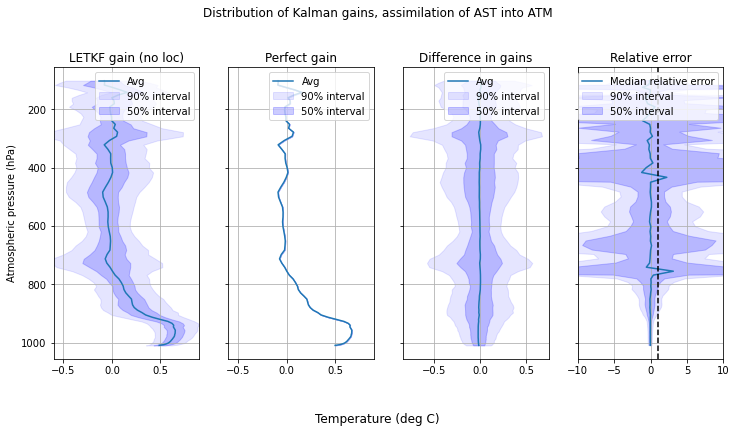

In [34]:
## Create subplots
fig, axs = plt.subplots(ncols=4, sharey=True) 

# Plot analysis mean (LETKF)
letkf_avg = np.mean(letkf_kgs, axis=1)
letkf_05 = np.percentile(letkf_kgs, 5, axis=1)
letkf_95 = np.percentile(letkf_kgs, 95, axis=1)
letkf_25 = np.percentile(letkf_kgs, 25, axis=1)
letkf_75 = np.percentile(letkf_kgs, 75, axis=1)
axs[0].plot(letkf_avg, atm_p[ind100hPa:], label='Avg')
axs[0].fill_betweenx(atm_p[ind100hPa:], letkf_05, letkf_95, color='b', alpha=.1, label='90% interval')
axs[0].fill_betweenx(atm_p[ind100hPa:], letkf_25, letkf_75, color='b', alpha=.2, label='50% interval')

# Plot analysis mean (perfect)
perf_avg = np.mean(perfect_kgs, axis=1)
perf_05 = np.percentile(perfect_kgs, 5, axis=1)
perf_95 = np.percentile(perfect_kgs, 95, axis=1)
perf_25 = np.percentile(perfect_kgs, 25, axis=1)
perf_75 = np.percentile(perfect_kgs, 75, axis=1)
axs[1].plot(perf_avg, atm_p[ind100hPa:], label='Avg')
axs[1].fill_betweenx(atm_p[ind100hPa:], perf_05, perf_95, color='b', alpha=.1, label='90% interval')
axs[1].fill_betweenx(atm_p[ind100hPa:], perf_25, perf_75, color='b', alpha=.2, label='50% interval')

# Plot analysis mean (no assimilation -- analaysis=background)
diff_inc = letkf_kgs - perfect_kgs
diff_avg = np.mean(diff_inc, axis=1)
diff_05 = np.percentile(diff_inc, 5, axis=1)
diff_95 = np.percentile(diff_inc, 95, axis=1)
diff_25 = np.percentile(diff_inc, 25, axis=1)
diff_75 = np.percentile(diff_inc, 75, axis=1)
axs[2].plot(diff_avg, atm_p[ind100hPa:], label='Avg')
axs[2].fill_betweenx(atm_p[ind100hPa:], diff_05, diff_95, color='b', alpha=.1, label='90% interval')
axs[2].fill_betweenx(atm_p[ind100hPa:], diff_25, diff_75, color='b', alpha=.2, label='50% interval')

# Plot relative errors
relative_errs = np.divide(letkf_kgs - perfect_kgs, perfect_kgs)
rel_avg = np.atleast_2d(np.median(relative_errs, axis=1)).transpose()
rel_05 = np.percentile(relative_errs, 5, axis=1)
rel_95 = np.percentile(relative_errs, 95, axis=1)
rel_25 = np.percentile(relative_errs, 25, axis=1)
rel_75 = np.percentile(relative_errs, 75, axis=1)
axs[3].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
axs[3].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
axs[3].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
axs[3].axvline(x=1,color='k', linestyle='--')

# Set xlims
axs[0].set_xlim([-0.6,0.9])
axs[1].set_xlim([-0.6,0.9])
#axs[2].set_xlim([-0.4,0.4])
axs[3].set_xlim([-10, 10])


# Legend
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[2].legend(loc='upper right')
axs[3].legend(loc='upper right')

# Set titles
fig.suptitle('Distribution of Kalman gains, assimilation of AST into ATM')
axs[0].set_title('LETKF gain (no loc)')
axs[1].set_title('Perfect gain')
axs[2].set_title('Difference in gains')
axs[3].set_title('Relative error')

# Adjust and label axes
axs[0].invert_yaxis()
axs[0].set_ylabel('Atmospheric pressure (hPa)')
fig.supxlabel('Temperature (deg C)')

# Adjust aesthetics

plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(2)
plt.rcParams['figure.figsize'] = [12,6]

# Save and show
plt.savefig(plot_dir+'/metric_parts')
plt.show()

### Plot metric for different localization radii with EnKF and LETKF

In [18]:
def create_distance_matrix(spatial_locations):
    N = len(spatial_locations) 
    # Create distance matrix
    dis = np.zeros((N,N))
    for jj in range(N):
        for ii in range(N):
            d = np.abs(spatial_locations[ii]-spatial_locations[jj])
            dis[ii, jj] = d
    return dis

In [ ]:
def compute_relative_error(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, use_loc=True):
    ## Set observation operator
    num_levs = this_cov.shape[0]
    HofX = np.zeros((1, num_levs))
    HofX[0, ind_ob] = 1
    
    ## Generate synthetic observations
    xt = this_avg + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1)) 
    y_ob = HofX @ ( xt + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1))) # obs error set to equal 'perfect' background error
    
    ## Generate ensemble
    rnd = np.random.normal(size=(num_levs, ens_size))
    x_err_ens = this_cov_sqrt @ rnd
    P_ens = np.cov(x_err_ens)
    x_ens = this_avg + x_err_ens

    ## Form background observation perturbations
    y_ens = HofX @ x_ens
    
    ## Set observation error variance equal to true variance
    R = HofX @ this_cov @ HofX.transpose()
    R_inv = np.reciprocal(R)
    
    ## Calculate background mean and innovation
    background_mean = np.mean(x_ens, 1)
    innovation = y_ob - HofX @ background_mean
    
    ## Compute perfect analysis
    perfect_innovation = y_ob - HofX @ this_avg
    perfect_kg = ( this_cov @ HofX.transpose() /(HofX @ this_cov @ HofX.transpose() + R))
    
    ## Take only state
    x_ens = x_ens[ind_state]
    background_mean = background_mean[ind_state]
    perfect_kg = perfect_kg[ind_state, 0]
    pos_state = pos_state[ind_state]
    this_cov = this_cov[np.ix_(ind_state, ind_state)]
    HofX = HofX[:,ind_state] # will have to be more clever than this to deal with cross-fluid assimilation
    P_ens = P_ens[np.ix_(ind_state, ind_state)]
    num_levs = len(ind_state)
    
    ## Get distance matrix
    dist = create_distance_matrix(pos_state)
    
    ## Get relative error for each localization radius
    num_loc_rads =  len(loc_rads_state)
    relative_error_enkf = np.empty((num_levs, num_loc_rads))
    relative_error_letkf = np.empty((num_levs, num_loc_rads))
    norm_rel_error_enkf = np.empty(num_loc_rads)
    norm_rel_error_letkf = np.empty(num_loc_rads)
    for loc_ind in range(num_loc_rads):
        # Get localization radius
        localization_radius = loc_rads_state[loc_ind]
        # EnKF update
        if use_loc:
            loc = gaspari_cohn(dist/(localization_radius/2))
            C = loc * P_ens # Localize ensemble covariance (inefficient, but OK for a small system)
        else:
            C = P_ens 
        enkf_kg = ( C @ HofX.transpose() )/( HofX @ C @ HofX.transpose() + R ) # Bad! But OK for single ob (scalar R)
        # LETKF update
        loc_rad_state = np.full_like(pos_state, localization_radius)
        analysis_mean_letkf = letkf(x_ens, y_ens, R_inv, y_ob, pos_state, pos_ob, loc_rad_state, loc_rad_ob, inflate=1, use_loc=use_loc)[0]
        letkf_kg = (analysis_mean_letkf - background_mean)/innovation
        # Compute relative error
        kg_err_enkf = perfect_kg - enkf_kg[:,0]
        kg_err_letkf = perfect_kg - letkf_kg
        # Store relative error
        relative_error_enkf[:, loc_ind] = kg_err_enkf#np.divide(kg_err_enkf, perfect_kg)
        relative_error_letkf[:, loc_ind] = kg_err_letkf#np.divide(kg_err_letkf, perfect_kg)
        norm_rel_error_enkf[loc_ind] = np.sqrt(np.sum(np.square(kg_err_enkf))) / np.sqrt(np.sum(np.square(perfect_kg)))
        norm_rel_error_letkf[loc_ind] = np.sqrt(np.sum(np.square(kg_err_letkf))) / np.sqrt(np.sum(np.square(perfect_kg)))
    
    return relative_error_enkf, norm_rel_error_enkf, relative_error_letkf, norm_rel_error_letkf

In [20]:
def run_multiple_trials_rel_err(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, num_trials=100, use_loc=True):
    relative_errors_enkf = np.empty((len(ind_state), len(loc_rads_state), num_trials))
    norm_rel_errors_enkf = np.empty((len(loc_rads_state), num_trials))
    relative_errors_letkf = np.empty((len(ind_state), len(loc_rads_state), num_trials))
    norm_rel_errors_letkf = np.empty((len(loc_rads_state), num_trials))
    for trial in range(num_trials):
        rerr_enkf, norm_rerr_enkf, rerr_letkf, norm_rerr_letkf = compute_relative_error(ind_state=ind_state, ind_ob=ind_ob, loc_rads_state=loc_rads_state, loc_rad_ob=loc_rad_ob, this_avg=this_avg, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, pos_state=pos_state, pos_ob=pos_ob, ens_size=ens_size, use_loc=use_loc)
        relative_errors_enkf[:, :, trial] = rerr_enkf
        norm_rel_errors_enkf[:, trial] = norm_rerr_enkf
        relative_errors_letkf[:, :, trial] = rerr_enkf
        norm_rel_errors_letkf[:, trial] = norm_rerr_letkf
    return relative_errors_enkf, norm_rel_errors_enkf, relative_errors_letkf, norm_rel_errors_letkf

In [21]:
# Set inputs for assimilation of ast into atm
ds = south_pacific
ind_state = np.arange(ind100hPa, num_atm_levs)
ind_ob = ind_ast
loc_rads_state = loc_rads_atm
loc_rad_ob = loc_rad_noloc
this_avg = sp_avg
this_cov = sp_cov
this_cov_sqrt = np.linalg.cholesky(this_cov)
atm_p = ds['atm_p'].mean(['lat', 'lon']).to_numpy()
pos_state = np.abs(np.log(atm_p) - np.log(atm_p[-1]))
pos_ob = pos_state[-1]
use_loc = True

In [22]:
relative_errors_enkf, norm_rel_errors_enkf, relative_errors_letkf, norm_rel_errors_letkf = run_multiple_trials_rel_err(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, num_trials=1000, use_loc=use_loc)

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:120: RuntimeWarning: invalid value encountered in reciprocal
  evals_inv = np.reciprocal(evals)
/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:44: RuntimeWarning: invalid value encountered in reciprocal
  gc[less2] = 1/12*dist[less2]**5 - .5*dist[less2]**4 + 0.625*dist[less2]**3 + 5/3*dist[less2]**2 - 5*dist[less2] + 4 - 2/3*dist[less2]**-1 ;


In [23]:
relative_errors_enkf_noloc, norm_rel_errors_enkf_noloc, relative_errors_letkf_noloc, norm_rel_errors_letkf_noloc = run_multiple_trials_rel_err(ind_state, ind_ob, [loc_rad_noloc], loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, num_trials=1000, use_loc=False)

In [112]:
# Get errors with localization 
for ii in range(norm_rel_errors_enkf.shape[0]):
    data_enkf = {'error': norm_rel_errors_enkf[ii,:], 
                 'loc_rad': loc_rads_state[ii],
                 'da_method': 'EnKF',
                 'localization': True}
    data_letkf = {'error': norm_rel_errors_letkf[ii,:], 
                  'loc_rad': loc_rads_state[ii],
                  'da_method': 'LETKF',
                  'localization': True}
    df_enkf_hold = pd.DataFrame(data_enkf)
    df_letkf_hold = pd.DataFrame(data_letkf)
    if ii == 0:
        df_manual = pd.concat([df_enkf_hold, df_letkf_hold])
    else:
        df_manual = pd.concat([df_manual, df_enkf_hold, df_letkf_hold])
# Get errors without localization
data_enkf = {'error': norm_rel_errors_enkf_noloc[0,:], 
             'loc_rad': np.Inf,
             'da_method': 'EnKF',
             'localization': False}
data_letkf = {'error': norm_rel_errors_letkf_noloc[0,:], 
              'loc_rad': np.Inf,
              'da_method': 'LETKF',
              'localization': False}
df_enkf_hold = pd.DataFrame(data_enkf)
df_letkf_hold = pd.DataFrame(data_letkf)
df_manual = pd.concat([df_manual, df_enkf_hold, df_letkf_hold])

In [24]:
def convert_to_dataarray(loc_rads_state, norm_rel_errors_enkf, norm_rel_errors_letkf, norm_rel_errors_enkf_noloc, norm_rel_errors_letkf_noloc):
    da_enkf = xr.DataArray( data=norm_rel_errors_enkf.T, dims=["trial", "loc_rad"], 
                           coords=dict(trial=np.arange(norm_rel_errors_enkf.shape[1]),loc_rad=loc_rads_state,da_method='EnKF'))
    da_letkf = xr.DataArray( data=norm_rel_errors_letkf.T, dims=["trial", "loc_rad"], 
                           coords=dict(trial=np.arange(norm_rel_errors_enkf.shape[1]),loc_rad=loc_rads_state,da_method='LETKF'))
    da_enkf_noloc = xr.DataArray( data=norm_rel_errors_enkf_noloc[0,:], dims=["trial"], 
                           coords=dict(trial=np.arange(norm_rel_errors_enkf_noloc.shape[1]), loc_rad=np.NAN, da_method='EnKF-NoLoc'))
    da_letkf_noloc = xr.DataArray( data=norm_rel_errors_letkf_noloc[0,:], dims=["trial"], 
                           coords=dict(trial=np.arange(norm_rel_errors_letkf_noloc.shape[1]), loc_rad=np.NAN, da_method='LETKF-NoLoc'))
    da = xr.concat([da_enkf, da_letkf], dim='da_method')
    da_noloc = xr.concat([da_enkf_noloc, da_letkf_noloc], dim='da_method')
    return da, da_noloc

In [25]:
da, da_noloc = convert_to_dataarray(loc_rads_state, norm_rel_errors_enkf, norm_rel_errors_letkf, norm_rel_errors_enkf_noloc, norm_rel_errors_letkf_noloc)

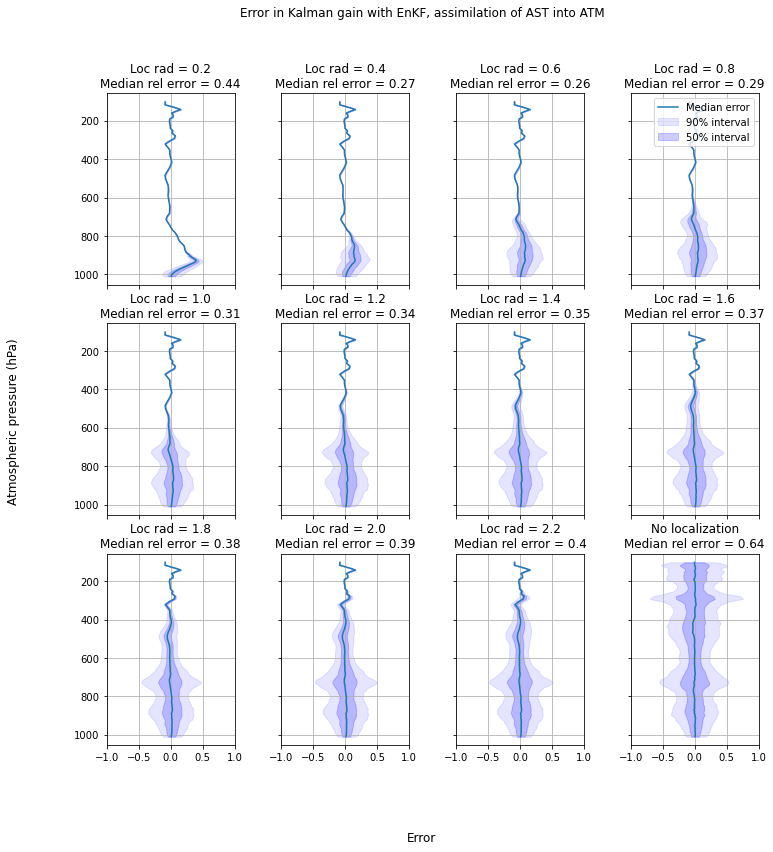

In [50]:
## Create subplots
fig, axs = plt.subplots(ncols=4, nrows=3, sharey=True, sharex=True) 

## Plot analysis errors with localization
for ind in range(len(loc_rads_state)):
    ax_col = ind % 4
    ax_row = int((ind - ax_col)/4)
    # Compute percentiles of relative error
    rerr = relative_errors_enkf[:, ind, :]
    rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
    rel_05 = np.percentile(rerr, 5, axis=1)
    rel_95 = np.percentile(rerr, 95, axis=1)
    rel_25 = np.percentile(rerr, 25, axis=1)
    rel_75 = np.percentile(rerr, 75, axis=1)
    # Plot relative errors
    #axs[ax_row, ax_col].axvline(x=1,color='k', linestyle='--')
    #axs[ax_row, ax_col].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
    axs[ax_row, ax_col].plot(rel_avg, atm_p[ind100hPa:], label='Median error')
    axs[ax_row, ax_col].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
    axs[ax_row, ax_col].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
    # Set title and legend
    med_norm_rerr = np.round(np.median(norm_rel_errors_enkf[ind,:]), 2)
    axs[ax_row, ax_col].set_title('Loc rad = '+str(loc_rads_state[ind])+'\nMedian rel error = '+str(med_norm_rerr))
    
## Plot analysis errors with no localization
# Compute percentiles of relative error
rerr = relative_errors_enkf_noloc[:,0,:]
rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
rel_05 = np.percentile(rerr, 5, axis=1)
rel_95 = np.percentile(rerr, 95, axis=1)
rel_25 = np.percentile(rerr, 25, axis=1)
rel_75 = np.percentile(rerr, 75, axis=1)
# Plot relative errors
#axs[2,3].axvline(x=1,color='k', linestyle='--')
#axs[2,3].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
axs[2,3].plot(rel_avg, atm_p[ind100hPa:], label='Median error')
axs[2,3].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
axs[2,3].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
# Set title and legend
med_norm_rerr = np.round(np.median(norm_rel_errors_enkf_noloc[0,:]), 2)
axs[2,3].set_title('No localization\nMedian rel error = '+str(med_norm_rerr))

# Set titles
fig.suptitle('Error in Kalman gain with EnKF, assimilation of AST into ATM')
axs[0,3].legend(loc='upper right')

# Adjust and label axes
#axs[0,0].set_xlim([-3.5,4.5])
axs[0,0].set_xlim([-1,1])
axs[0,0].invert_yaxis()
fig.supylabel('Atmospheric pressure (hPa)')
#fig.supxlabel('Relative error')
fig.supxlabel('Error')

# Adjust aesthetics
#plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(1.5)
plt.rcParams['figure.figsize'] = [12,12]

# Save and show
#plt.savefig(plot_dir+'/relative_error_by_loc_rad_enkf')
plt.savefig(plot_dir+'/absolute_error_by_loc_rad_enkf')
plt.show()

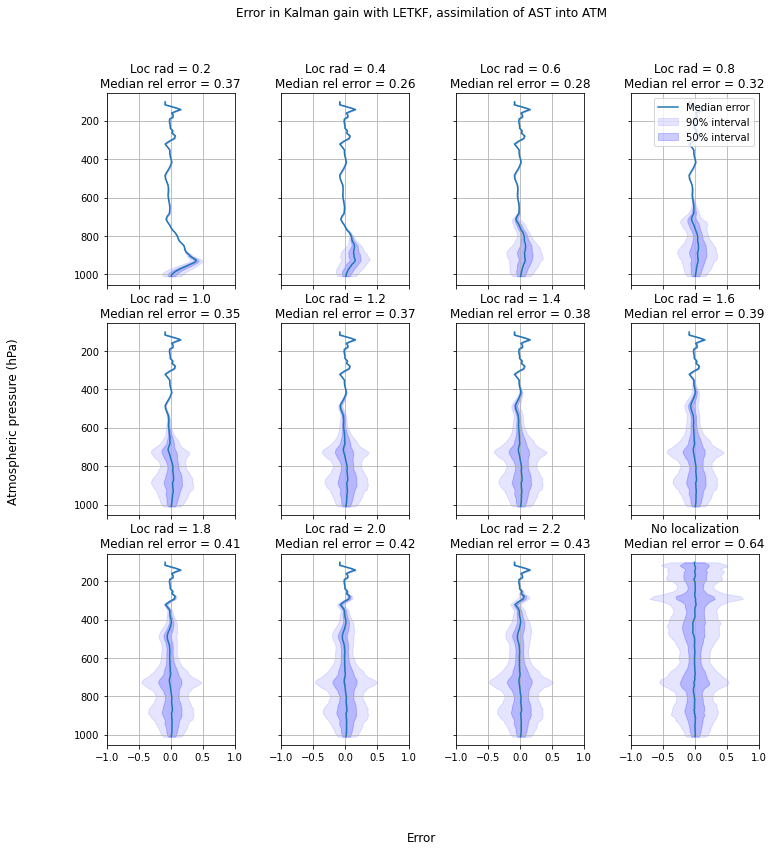

In [51]:
## Create subplots
fig, axs = plt.subplots(ncols=4, nrows=3, sharey=True, sharex=True) 

## Plot analysis errors with localization
for ind in range(len(loc_rads_state)):
    ax_col = ind % 4
    ax_row = int((ind - ax_col)/4)
    # Compute percentiles of relative error
    rerr = relative_errors_letkf[:, ind, :]
    rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
    rel_05 = np.percentile(rerr, 5, axis=1)
    rel_95 = np.percentile(rerr, 95, axis=1)
    rel_25 = np.percentile(rerr, 25, axis=1)
    rel_75 = np.percentile(rerr, 75, axis=1)
    # Plot relative errors
    #axs[ax_row, ax_col].axvline(x=1,color='k', linestyle='--')
    #axs[ax_row, ax_col].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
    axs[ax_row, ax_col].plot(rel_avg, atm_p[ind100hPa:], label='Median error')
    axs[ax_row, ax_col].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
    axs[ax_row, ax_col].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
    # Set title and legend
    med_norm_rerr = np.round(np.median(norm_rel_errors_letkf[ind,:]), 2)
    axs[ax_row, ax_col].set_title('Loc rad = '+str(loc_rads_state[ind])+'\nMedian rel error = '+str(med_norm_rerr))
    
## Plot analysis errors with no localization
# Compute percentiles of relative error
rerr = relative_errors_letkf_noloc[:,0,:]
rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
rel_05 = np.percentile(rerr, 5, axis=1)
rel_95 = np.percentile(rerr, 95, axis=1)
rel_25 = np.percentile(rerr, 25, axis=1)
rel_75 = np.percentile(rerr, 75, axis=1)
# Plot relative errors
#axs[2,3].axvline(x=1,color='k', linestyle='--')
#axs[2,3].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
axs[2,3].plot(rel_avg, atm_p[ind100hPa:], label='Median error')
axs[2,3].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
axs[2,3].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
# Set title and legend
med_norm_rerr = np.round(np.median(norm_rel_errors_letkf_noloc[0,:]), 2)
axs[2,3].set_title('No localization\nMedian rel error = '+str(med_norm_rerr))

# Set titles
fig.suptitle('Error in Kalman gain with LETKF, assimilation of AST into ATM')
axs[0,3].legend(loc='upper right')

# Adjust and label axes
#axs[0,0].set_xlim([-3.5,4.5])
axs[0,0].set_xlim([-1,1])
axs[0,0].invert_yaxis()
fig.supylabel('Atmospheric pressure (hPa)')
#fig.supxlabel('Relative error')
fig.supxlabel('Error')

# Adjust aesthetics
#plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(1.5)
plt.rcParams['figure.figsize'] = [12,12]

# Save and show
#plt.savefig(plot_dir+'/relative_error_by_loc_rad_letkf')
plt.savefig(plot_dir+'/absolute_error_by_loc_rad_letkf')
plt.show()

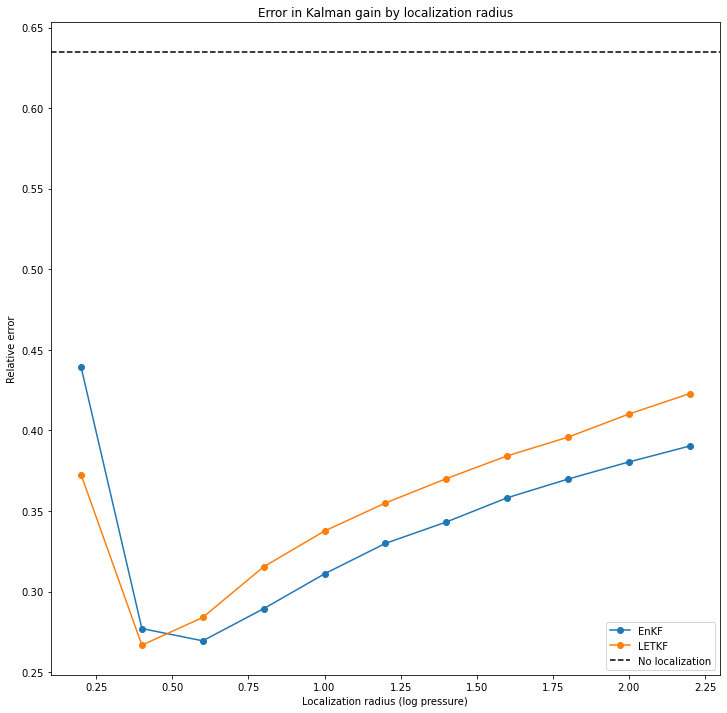

In [118]:
plt.plot(df['loc_rad'], df.sel(da_method='EnKF').median('trial'), '-o', label='EnKF')
plt.plot(df['loc_rad'], df.sel(da_method='LETKF').median('trial'), '-o', label='LETKF')
plt.axhline(y=df_noloc.median(), color='k', linestyle='--', label='No localization')
plt.legend()

# Adjust and label axes
plt.title('Error in Kalman gain by localization radius')
plt.ylabel('Relative error')
plt.xlabel('Localization radius (log pressure)')

# Adjust aesthetics
plt.rcParams['figure.figsize'] = [12,12]

# Save and show
plt.savefig(plot_dir+'/relative_error_by_loc_rad')
plt.show()

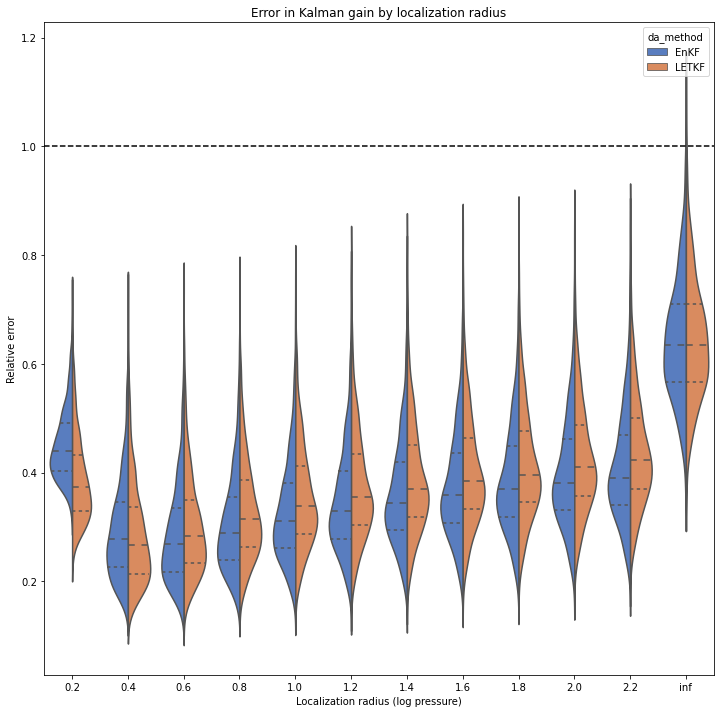

In [125]:
#plt.plot(loc_rads_state, np.median(norm_rel_errors_enkf, axis=1), '-o', label='EnKF')
#plt.plot(loc_rads_state, np.median(norm_rel_errors_letkf, axis=1), '-o', label='LETKF')
#plt.axhline(y=np.median(norm_rel_errors_letkf_noloc), color='k', linestyle='--', label='No localization')
#plt.legend()

sns.violinplot(data=df_manual, x='loc_rad', y='error', hue='da_method', split=True, inner='quartiles', palette="muted")
plt.axhline(y=1, color='k', linestyle='--', label='Assim worse than no assim')


# Adjust and label axes
plt.title('Error in Kalman gain by localization radius')
plt.ylabel('Relative error')
plt.xlabel('Localization radius (log pressure)')

# Adjust aesthetics
plt.rcParams['figure.figsize'] = [12,12]

# Save and show
plt.savefig(plot_dir+'/relative_error_by_loc_rad_violin')
plt.show()

### Compare DA update to 'perfect' background and 'truth'

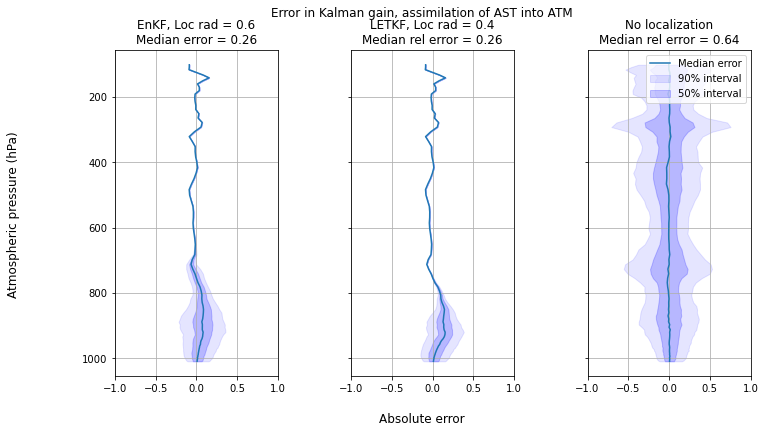

In [53]:
## Create subplots
fig, axs = plt.subplots(ncols=3, sharey=True, sharex=True) 

## Find best localization radius for EnKF and LETKF
ind_best_enkf = np.argmin(np.median(norm_rel_errors_enkf, axis=1))
ind_best_letkf = np.argmin(np.median(norm_rel_errors_letkf, axis=1))

## Plot Analysis Error for EnKF with best localization radius
# Compute percentiles of relative error
rerr = relative_errors_enkf[:, ind_best_enkf, :]
rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
rel_05 = np.percentile(rerr, 5, axis=1)
rel_95 = np.percentile(rerr, 95, axis=1)
rel_25 = np.percentile(rerr, 25, axis=1)
rel_75 = np.percentile(rerr, 75, axis=1)
# Plot relative errors
#axs[0].axvline(x=1,color='k', linestyle='--')
#axs[0].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
axs[0].plot(rel_avg, atm_p[ind100hPa:], label='Median error')
axs[0].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
axs[0].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
# Set title and legend
med_norm_rerr = np.round(np.median(norm_rel_errors_enkf[ind_best_enkf,:]), 2)
axs[0].set_title('EnKF, Loc rad = '+str(loc_rads_state[ind_best_enkf])+'\nMedian error = '+str(med_norm_rerr))

## Plot Analysis Error for LETKF with best localization radius
# Compute percentiles of relative error
rerr = relative_errors_letkf[:, ind_best_letkf, :]
rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
rel_05 = np.percentile(rerr, 5, axis=1)
rel_95 = np.percentile(rerr, 95, axis=1)
rel_25 = np.percentile(rerr, 25, axis=1)
rel_75 = np.percentile(rerr, 75, axis=1)
# Plot relative errors
#axs[1].axvline(x=1,color='k', linestyle='--')
#axs[1].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
axs[1].plot(rel_avg, atm_p[ind100hPa:], label='Median error')
axs[1].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
axs[1].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
# Set title and legend
med_norm_rerr = np.round(np.median(norm_rel_errors_letkf[ind_best_letkf,:]), 2)
axs[1].set_title('LETKF, Loc rad = '+str(loc_rads_state[ind_best_letkf])+'\nMedian rel error = '+str(med_norm_rerr))
    
## Plot analysis errors with no localization
# Compute percentiles of relative error
rerr = relative_errors_letkf_noloc[:,0,:]
rel_avg = np.atleast_2d(np.median(rerr, axis=1)).transpose()
rel_05 = np.percentile(rerr, 5, axis=1)
rel_95 = np.percentile(rerr, 95, axis=1)
rel_25 = np.percentile(rerr, 25, axis=1)
rel_75 = np.percentile(rerr, 75, axis=1)
# Plot relative errors
#axs[2].axvline(x=1,color='k', linestyle='--')
#axs[2].plot(rel_avg, atm_p[ind100hPa:], label='Median relative error')
axs[2].plot(rel_avg, atm_p[ind100hPa:], label='Median error')
axs[2].fill_betweenx(atm_p[ind100hPa:], rel_05, rel_95, color='b', alpha=.1, label='90% interval')
axs[2].fill_betweenx(atm_p[ind100hPa:], rel_25, rel_75, color='b', alpha=.2, label='50% interval')
# Set title and legend
med_norm_rerr = np.round(np.median(norm_rel_errors_letkf_noloc[0,:]), 2)
axs[2].set_title('No localization\nMedian rel error = '+str(med_norm_rerr))


# Set titles
fig.suptitle('Error in Kalman gain, assimilation of AST into ATM')
axs[2].legend(loc='upper right')

# Adjust and label axes
#axs[0].set_xlim([-3.5,4.5])
axs[0].set_xlim([-1,1])
axs[0].invert_yaxis()
fig.supylabel('Atmospheric pressure (hPa)')
#fig.supxlabel('Relative error')
fig.supxlabel('Absolute error')

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(2)
plt.rcParams['figure.figsize'] = [12,6]

# Save and show
#plt.savefig(plot_dir+'/relative_error_with_various_increments')
plt.savefig(plot_dir+'/absolute_error_with_various_increments')
plt.show()

### Compare increments and Kalman gains

In [62]:
def get_increments(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, use_loc=True):
    ## Set observation operator
    num_levs = this_cov.shape[0]
    HofX = np.zeros((1, num_levs))
    HofX[0, ind_ob] = 1
    
    ## Generate synthetic observations
    xt = this_avg + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1)) 
    y_ob = HofX @ ( xt + this_cov_sqrt @ np.random.normal(scale=1, size=(num_levs, 1))) # obs error set to equal 'perfect' background error
    
    ## Generate ensemble
    rnd = np.random.normal(size=(num_levs, ens_size))
    x_err_ens = this_cov_sqrt @ rnd
    P_ens = np.cov(x_err_ens)
    x_ens = this_avg + x_err_ens

    ## Form background observation perturbations
    y_ens = HofX @ x_ens
    
    ## Set observation error variance equal to true variance
    R = HofX @ this_cov @ HofX.transpose()
    R_inv = np.reciprocal(R)
    
    ## Calculate analysis increments
    background_mean = np.mean(x_ens, 1)
    innovation = y_ob - HofX @ background_mean
    perfect_kg = ( this_cov @ HofX.transpose() /(HofX @ this_cov @ HofX.transpose() + R))
    perfect_innovation = y_ob - HofX @ this_avg
    
    ## Take only state
    x_ens = x_ens[ind_state,:]
    background_mean = background_mean[ind_state]
    perfect_kg = perfect_kg[ind_state, 0]
    pos_state = pos_state[ind_state]
    
    ## Get analysis mean
    loc_rad_state = np.full_like(pos_state, loc_rads_state)
    analysis_mean = letkf(x_ens, y_ens, R_inv, y_ob, pos_state, pos_ob, loc_rad_state, loc_rad_ob, inflate=1, use_loc=use_loc)[0]
    increment = (analysis_mean - background_mean)
    letkf_kg = increment / innovation
    
    return letkf_kg, increment, innovation

In [65]:
def get_multiple_increments(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_size = 20, num_trials=5, use_loc=True):
    letkf_kgs = np.empty((len(ind_state), num_trials))
    letkf_incs = np.empty((len(ind_state), num_trials))
    innovations = np.empty(num_trials)
    for trial in range(num_trials):
        letkf_kg, increment, innovation = get_increments(ind_state=ind_state, ind_ob=ind_ob, loc_rads_state=loc_rads_state, loc_rad_ob=loc_rad_ob, this_avg=this_avg, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, pos_state=pos_state, pos_ob=pos_ob, ens_size=ens_size, use_loc=use_loc)
        letkf_kgs[:, trial] = letkf_kg
        letkf_incs[:, trial] = increment
        innovations[trial] = innovation
    return letkf_kgs, letkf_incs, innovations

In [66]:
letkf_kgs, letkf_incs, innovations = get_multiple_increments(ind_state, ind_ob, [loc_rad_noloc], loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, num_trials=5, use_loc=False)

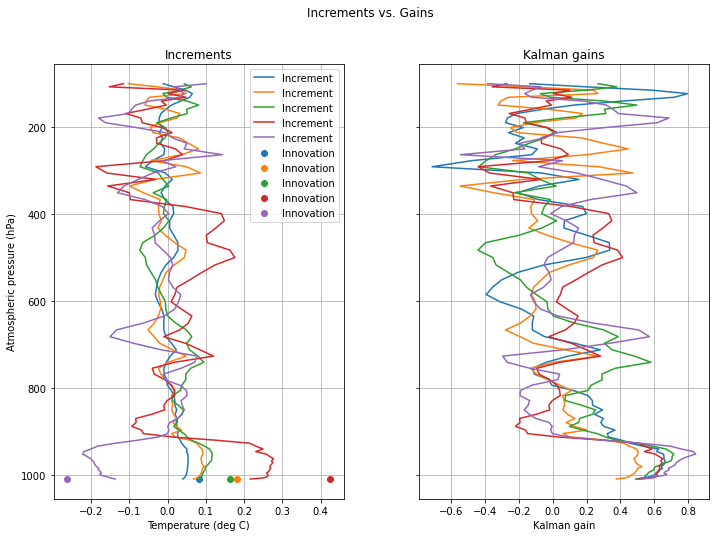

In [86]:
## Create subplots
fig, axs = plt.subplots(ncols=2, nrows=1, sharey=True) 

# Plot
axs[0].plot(letkf_incs, atm_p[ind100hPa:], label = 'Increment')
plt.gca().set_prop_cycle(None)
for i in range(5):
    axs[0].scatter(innovations[i], atm_p[-1], label = 'Innovation')
    
# Plot
axs[1].plot(letkf_kgs, atm_p[ind100hPa:])

# Set titles
fig.suptitle('Increments vs. Gains')
axs[0].legend(loc='upper right')
axs[0].set_title('Increments')
axs[1].set_title('Kalman gains')

# Adjust and label axes
axs[0].invert_yaxis()
axs[0].set_ylabel('Atmospheric pressure (hPa)')
axs[0].set_xlabel('Temperature (deg C)')
axs[1].set_xlabel('Kalman gain')

# Adjust aesthetics
#plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(1.5)
plt.rcParams['figure.figsize'] = [12,8]

# Save and show
plt.savefig(plot_dir+'/increments_vs_gains')
plt.show()

In [132]:
ens_sizes = [2, 4, 8, 16, 32, 64, 128]
loc_rads_state = [0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:
# Set inputs for assimilation of ast into atm
ds = south_pacific
ind_state = np.arange(ind100hPa, num_atm_levs)
ind_ob = ind_ast
#loc_rads_state = loc_rads_atm
loc_rad_ob = loc_rad_noloc
this_avg = sp_avg
this_cov = sp_cov
this_cov_sqrt = np.linalg.cholesky(this_cov)
atm_p = ds['atm_p'].mean(['lat', 'lon']).to_numpy()
pos_state = np.abs(np.log(atm_p) - np.log(atm_p[-1]))
pos_ob = pos_state[-1]
use_loc = True

In [135]:
def run_multiple_trials_norm_err(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_sizes, num_trials=100, use_loc=True):
    norm_rel_errors_enkf = np.empty((len(ens_sizes), len(loc_rads_state), num_trials))
    norm_rel_errors_letkf = np.empty((len(ens_sizes), len(loc_rads_state), num_trials))
    for ens_ind in range(len(ens_sizes)):
        ens_size = ens_sizes[ens_ind]
        print(ens_size)
        for trial in range(num_trials):
            _, norm_rerr_enkf, _, norm_rerr_letkf = compute_relative_error(ind_state=ind_state, ind_ob=ind_ob, loc_rads_state=loc_rads_state, loc_rad_ob=loc_rad_ob, this_avg=this_avg, this_cov=this_cov, this_cov_sqrt=this_cov_sqrt, pos_state=pos_state, pos_ob=pos_ob, ens_size=ens_size, use_loc=use_loc)
            norm_rel_errors_enkf[ens_ind, :, trial] = norm_rerr_enkf
            norm_rel_errors_letkf[ens_ind, :, trial] = norm_rerr_letkf
    return norm_rel_errors_enkf, norm_rel_errors_letkf

In [136]:
norm_rel_errors_enkf, norm_rel_errors_letkf = run_multiple_trials_norm_err(ind_state, ind_ob, loc_rads_state, loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_sizes, num_trials=100, use_loc=use_loc)

2


/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:120: RuntimeWarning: invalid value encountered in reciprocal
  evals_inv = np.reciprocal(evals)


4
8
16
32
64
128


In [147]:
norm_rel_errors_enkf_noloc, norm_rel_errors_letkf_noloc = run_multiple_trials_norm_err(ind_state, ind_ob, [loc_rad_noloc], loc_rad_ob, this_avg, this_cov, this_cov_sqrt, pos_state, pos_ob, ens_sizes, num_trials=100, use_loc=False)

2


/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts/letkf.py:120: RuntimeWarning: invalid value encountered in reciprocal
  evals_inv = np.reciprocal(evals)


4
8
16
32
64
128


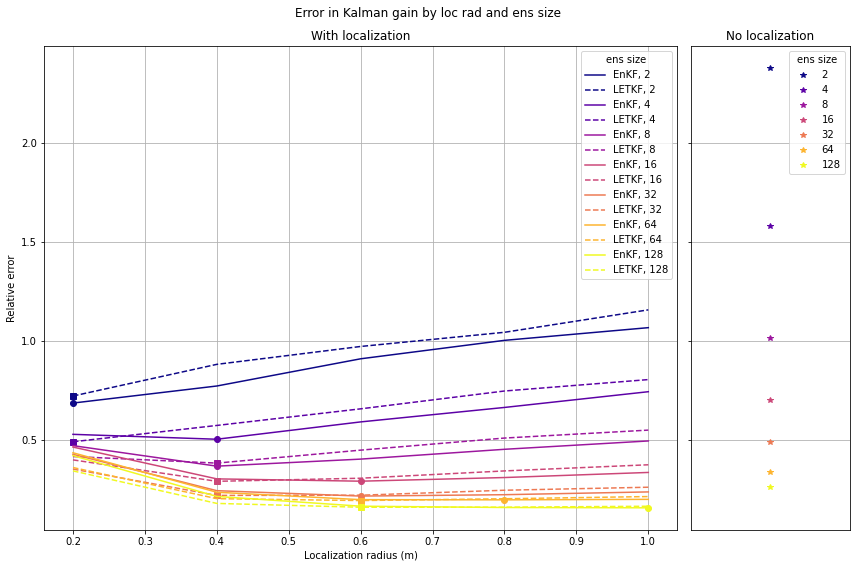

In [185]:
## Create subplots
fig, axs = plt.subplots(ncols=2, nrows=1, sharey=True, gridspec_kw={'width_ratios': [4, 1]}) 

## Process data
data_enkf = np.median(norm_rel_errors_enkf, axis=2)
data_letkf = np.median(norm_rel_errors_letkf, axis=2)
data_enkf_noloc = np.median(norm_rel_errors_enkf_noloc[:,0,:], axis=1)
data_letkf_noloc = np.median(norm_rel_errors_letkf_noloc[:,0,:], axis=1)
n = data.shape[0]
colors = plt.cm.plasma(np.linspace(0,1,n))

# Plot data
for i in range(n):
    axs[0].plot(loc_rads_state, data_enkf[i,:], color=colors[i], label='EnKF, '+str(ens_sizes[i]))
    axs[0].plot(loc_rads_state, data_letkf[i,:], '--', color=colors[i], label='LETKF, '+str(ens_sizes[i]))
    min_ind_enkf = np.argmin(data_enkf[i,:])
    min_ind_letkf = np.argmin(data_letkf[i,:])
    axs[0].plot(loc_rads_state[min_ind_enkf], data_enkf[i, min_ind_enkf], 'o', color=colors[i])
    axs[0].plot(loc_rads_state[min_ind_letkf], data_letkf[i, min_ind_letkf], 's', color=colors[i])
    axs[1].plot( data_enkf_noloc[i], '*', color=colors[i], label=ens_sizes[i])

# Legend
axs[0].legend(title='ens size', loc='upper right')
axs[1].legend(title='ens size', loc='upper right')
    
# Labels
axs[0].set_xlabel('Localization radius (log pressure)')
axs[0].set_ylabel('Relative error')
axs[0].set_title('With localization')
axs[1].set_title('No localization')
plt.suptitle('Error in Kalman gain by loc rad and ens size')

# Add/remove grid lines
axs[0].grid()
axs[1].grid(axis='y')
axs[1].xaxis.set_ticklabels([])
axs[1].get_xaxis().set_visible(False)

# Save and show
plt.tight_layout()
plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/err_vs_loc_rad_and_ens_size')
plt.show()